In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm

In [4]:
import matplotlib.pyplot as plt

In [5]:
from rqc.CT_quantum_stat_mech import * 

In [144]:
from rqc.CT_quantum_stat_mech_O1 import *

In [156]:
ct = CT_quantum_stat_mech(L=4)

In [22]:
ct.vec+=1

In [173]:
ct.Bernouli()

In [16]:
ct.control()

In [223]:
ct.vec

array([0., 0., 0., 0.])

In [224]:
ct.variance()

np.float64(0.25)

In [225]:
ct.variance_FDW()

np.float64(1.43359375)

In [219]:
ct_ = CT_quantum_stat_mech_O1(L=4)

In [220]:
ct_.FDW=4

In [221]:
ct_.variance()

0.25

In [226]:
ct_.variance_FDW()

1.43359375

In [111]:
def run(L,p,seed_C=0):
    ct = CT_quantum_stat_mech(L=L,seed_C=seed_C)
    for i in range(2*ct.L**2):
    # for i in range(4*ct.L**2):
        ct.random_circuit(p=p)
    var_Mz, var_FDW = ct.variance(), ct.variance_FDW()
    return var_Mz, var_FDW

In [66]:
def run_T(L,p,seed_C=0):
    ct = CT_quantum_stat_mech(L=L,seed_C=seed_C)
    Tmax = 2*ct.L**2
    var_Mz= np.zeros(Tmax+1,)
    var_FDW= np.zeros(Tmax+1,)
    var_Mz[0], var_FDW[0] = ct.variance(), ct.variance_FDW()
    for i in range(Tmax):
        ct.random_circuit(p=p)
        var_Mz[i+1], var_FDW[i+1] = ct.variance(), ct.variance_FDW()
    return var_Mz, var_FDW

In [183]:
def run_O1(L,p,seed_C=0):
    ct = CT_quantum_stat_mech_O1(L=L,seed_C=seed_C)
    for i in range(2*ct.L**2):
    # for i in range(4*ct.L**2):
        ct.random_circuit(p=p)
    var_Mz, var_FDW = ct.variance(), ct.variance_FDW()
    return var_Mz, var_FDW

In [213]:
def run_O1_T(L,p,seed_C=0):
    ct = CT_quantum_stat_mech_O1(L=L,seed_C=seed_C)
    Tmax = 2*ct.L**2
    var_Mz= np.zeros(Tmax+1,)
    var_FDW= np.zeros(Tmax+1,)
    var_Mz[0], var_FDW[0] = ct.variance(), ct.variance_FDW()
    for i in range(Tmax):
        ct.random_circuit(p=p)
        var_Mz[i+1] =ct.variance()
        var_FDW[i+1] = ct.variance_FDW()
    return var_Mz, var_FDW

In [203]:
var_Mz, var_FDW = run_T(L=100,p=0.5,seed_C=0)

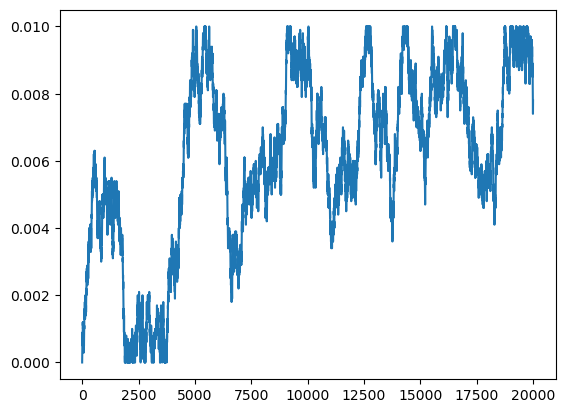

In [204]:
plt.plot(var_Mz)

In [227]:
var_Mz, var_FDW = run_O1_T(L=100,p=0.5,seed_C=0)

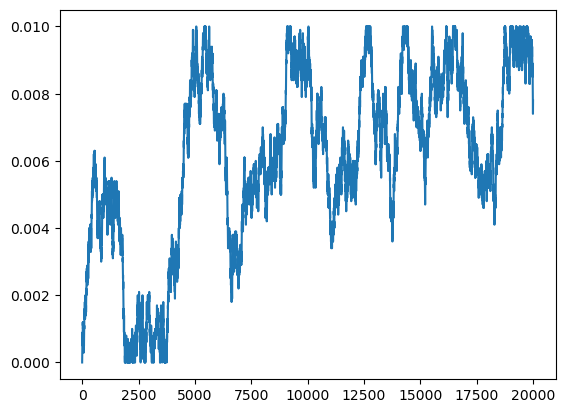

In [228]:
plt.plot(var_Mz)

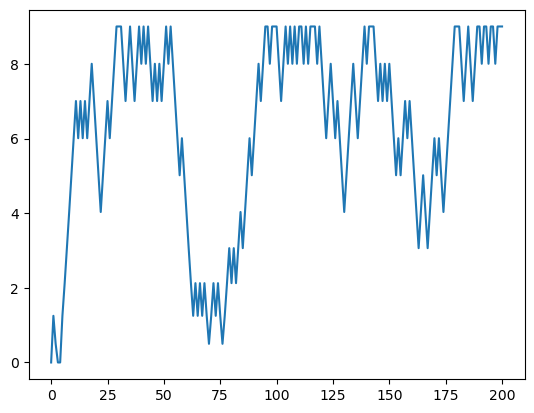

In [69]:
plt.plot(var_FDW)

In [ ]:
L_list=[10,20,30,40]
# p_list = (np.linspace(.2,.8,19))
p_list= [0.5]
seed_list = np.arange(10000)
var_Mz_list_short={}
var_FDW_list_short = {} 
for L in (L_list):
    var_Mz_list_short[L] = np.zeros((len(p_list),len(seed_list),2*L**2+1 ))
    var_FDW_list_short[L] = np.zeros((len(p_list),len(seed_list),2*L**2+1 ))
    for p_idx,p in (enumerate(p_list)):
        for i,seed in tqdm(enumerate(seed_list)):
            var_Mz_list_short[L][p_idx,i], var_FDW_list_short[L][p_idx,i] = run_O1_T(L,p,seed)


5000it [00:02, 2411.58it/s]
5000it [00:07, 692.17it/s]
5000it [00:20, 247.63it/s]
5000it [00:33, 149.61it/s]


In [236]:
from joblib import Parallel, delayed

L_list=[10,20,30,40]
p_list= [0.5]
seed_list = np.arange(100000)
var_Mz_list_short={}
var_FDW_list_short = {} 

for L in L_list:
    var_Mz_list_short[L] = np.zeros((len(p_list),len(seed_list),2*L**2+1 ))
    var_FDW_list_short[L] = np.zeros((len(p_list),len(seed_list),2*L**2+1 ))
    for p_idx,p in enumerate(p_list):
        # Parallelize over seeds
        results = Parallel(n_jobs=-1)(
            delayed(run_O1_T)(L, p, seed) for seed in tqdm(seed_list, desc=f'L={L}, p={p}')
        )
        # Unpack results
        for i, (var_Mz, var_FDW) in enumerate(results):
            var_Mz_list_short[L][p_idx,i] = var_Mz
            var_FDW_list_short[L][p_idx,i] = var_FDW

L=40, p=0.5: 100%|██████████| 100000/100000 [02:47<00:00, 598.15it/s]


In [237]:
var_Mz_list_short[10].shape

(1, 100000, 201)

(1, 1000)

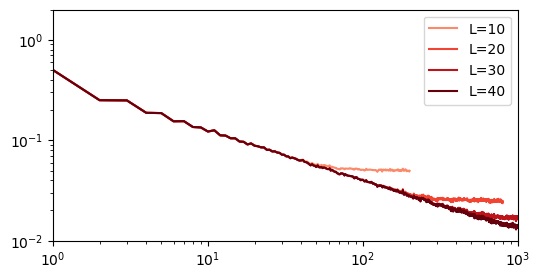

In [242]:
fig,ax=plt.subplots(figsize=(6,3))
color_list = plt.cm.Reds(np.linspace(0.4,1,len(L_list)))
for L, color in zip(L_list, color_list):
    # plt.plot((var_Mz_list_short[L][0]==0).mean(axis=0))
    x = np.arange(2*L**2+1)
    y = (var_Mz_list_short[L][0]==0).mean(axis=0)
    ax.plot(x,y, label=f'L={L}', color=color)
    # plt.plot(x/L**2, y*L)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_ylim(1e-2,2)
plt.xlim(1,1000)


(1, 1000)

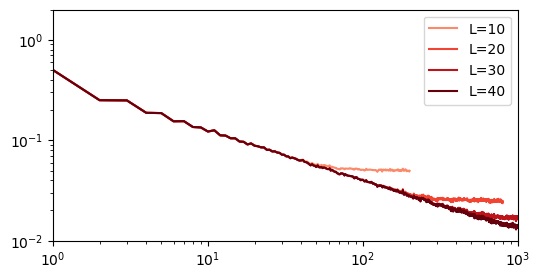

In [243]:
fig,ax=plt.subplots(figsize=(6,3))
color_list = plt.cm.Reds(np.linspace(0.4,1,len(L_list)))
for L, color in zip(L_list, color_list):
    x = np.arange(2*L**2+1)
    y = (var_FDW_list_short[L][0]==0).mean(axis=0)
    ax.plot(x,y, label=f'L={L}', color=color)
    # plt.plot(x/L**2, y*L)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_ylim(1e-2,2)
plt.xlim(1,1000)


(1, 1000)

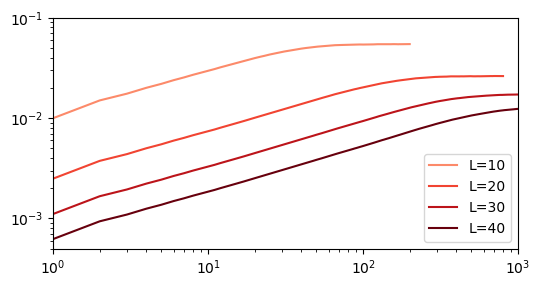

In [250]:

fig,ax=plt.subplots(figsize=(6,3))
color_list = plt.cm.Reds(np.linspace(0.4,1,len(L_list)))
for L, color in zip(L_list, color_list):
    # plt.plot((var_Mz_list_short[L][0]==0).mean(axis=0))
    x = np.arange(2*L**2+1)
    y = (var_Mz_list_short[L][0]).mean(axis=0)
    ax.plot(x,y, label=f'L={L}', color=color)
    # plt.plot(x/L**2, y*L)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_ylim(.5e-3,1e-1)
plt.xlim(1,1000)


(1, 2000)

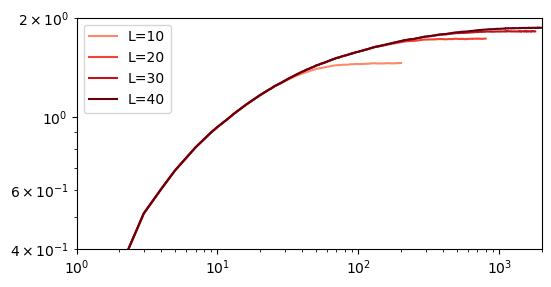

In [258]:

fig,ax=plt.subplots(figsize=(6,3))
color_list = plt.cm.Reds(np.linspace(0.4,1,len(L_list)))
for L, color in zip(L_list, color_list):
    x = np.arange(2*L**2+1)+1
    y = (var_FDW_list_short[L][0]).mean(axis=0)
    ax.plot(x,y, label=f'L={L}', color=color)
    # plt.plot(x/L**2, y*L)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
# ax.set_ylim(.5e-3,1e-1)
ax.set_ylim(.4,2)

ax.set_xlim(1,2000)


(1, 1000)

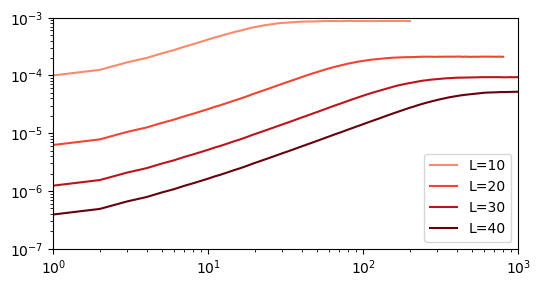

In [254]:
fig,ax=plt.subplots(figsize=(6,3))
color_list = plt.cm.Reds(np.linspace(0.4,1,len(L_list)))
for L, color in zip(L_list, color_list):
    # plt.plot((var_Mz_list_short[L][0]==0).mean(axis=0))
    x = np.arange(2*L**2+1)
    y = (var_Mz_list_short[L][0]).var(axis=0)
    ax.plot(x,y, label=f'L={L}', color=color)
    # plt.plot(x/L**2, y*L)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_ylim(1e-7,1e-3)
plt.xlim(1,1000)


(1, 2000)

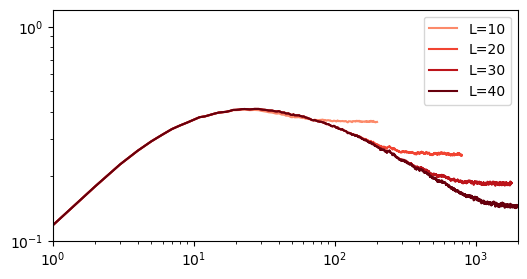

In [265]:

fig,ax=plt.subplots(figsize=(6,3))
color_list = plt.cm.Reds(np.linspace(0.4,1,len(L_list)))
for L, color in zip(L_list, color_list):
    x = np.arange(2*L**2+1)
    y = (var_FDW_list_short[L][0]).var(axis=0)
    ax.plot(x,y, label=f'L={L}', color=color)
    # plt.plot(x/L**2, y*L)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
# ax.set_ylim(.5e-3,1e-1)
# ax.set_ylim(.4,2)
ax.set_ylim(1e-1,1.2)

ax.set_xlim(1,2000)


In [269]:
import pickle

In [270]:
with open('stat_mech_Mz_FDW.pickle', 'wb') as f:
    pickle.dump({'var_Mz':var_Mz_list_short, 'var_FDW':var_FDW_list_short}, f)

In [271]:
import lzma
with lzma.open('stat_mech_Mz_FDW.xz', 'wb') as f:
    pickle.dump({'var_Mz':var_Mz_list_short, 'var_FDW':var_FDW_list_short}, f)

In [ ]:
var_FDW_list_short

In [25]:
L_list=[10,20]
# p_list = (np.linspace(.2,.8,19))
p_list = [0.5]
seed_list = np.arange(2000)
var_Mz_list = np.zeros((len(L_list),len(p_list),len(seed_list)))
var_FDW_list = np.zeros((len(L_list),len(p_list),len(seed_list)))

for L_idx, L in enumerate(L_list):
    for p_idx,p in (enumerate(p_list)):
        for i,seed in tqdm(enumerate(seed_list)):
            var_Mz_list[L_idx,p_idx,i], var_FDW_list[L_idx,p_idx,i] = run(L,p,seed)
    

0it [00:00, ?it/s]

1it [00:04,  4.53s/it]
1it [00:04,  4.53s/it]
1it [00:14, 14.90s/it]


In [27]:
var_Mz_list.shape

(2, 1, 2000)

In [24]:
p_list[9]

0.5

In [59]:
L_list=[10,20,30]
p_list = (np.linspace(.2,.8,19))
seed_list = np.arange(100)
var_list = np.zeros((len(L_list),len(p_list),len(seed_list)))
for L_idx, L in enumerate(L_list):
    for p_idx,p in tqdm(enumerate(p_list)):
        for i,seed in enumerate(seed_list):
            var_list[L_idx,p_idx,i] = run(L,p,seed)
    

19it [00:07,  2.69it/s]
19it [00:28,  1.50s/it]
19it [00:58,  3.08s/it]


In [112]:
L_list=[10,20,]
# p_list = (np.linspace(.2,.8,19))
p_list= [0.5]
seed_list = np.arange(10000)
var_Mz_list_short = np.zeros((len(L_list),len(p_list),len(seed_list)))
var_FDW_list_short = np.zeros((len(L_list),len(p_list),len(seed_list)))
for L_idx, L in enumerate(L_list):
    for p_idx,p in (enumerate(p_list)):
        for i,seed in tqdm(enumerate(seed_list)):
            var_Mz_list_short[L_idx,p_idx,i], var_FDW_list_short[L_idx,p_idx,i] = run(L,p,seed)


0it [00:00, ?it/s]

10000it [00:20, 482.65it/s]
10000it [01:21, 122.50it/s]


In [58]:
(var_Mz_list_short[0,0]==0).mean()

np.float64(0.0482)

In [57]:
(var_Mz_list_short[1,0]==0).mean()

np.float64(0.0226)

In [47]:
(var_Mz_list_short[2,0]==0).mean()

np.float64(0.0149)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_509355/2348753722.py:6: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('$\sigma^2$')


Text(0, 0.5, 'PDF')

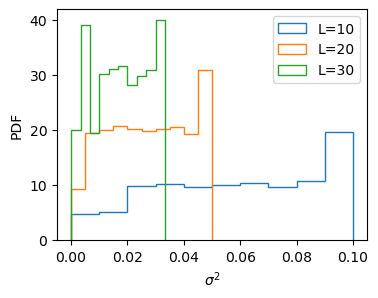

In [39]:
fig,ax=plt.subplots(figsize=(4,3))
for i in range(0,3):
    (ax.hist(var_Mz_list_short[i,0],label=f'L={L_list[i]}',histtype='step',bins=10,density=True))
ax.legend()

ax.set_xlabel('$\sigma^2$')
ax.set_ylabel('PDF')
# fig.savefig('../Paper_CIPT/Fig/circ_fluct_traj_fluct_0.5.pdf',bbox_inches='tight')

In [119]:
(var_FDW_list_short[0,0]==0).mean()

np.float64(0.0482)

In [ ]:
(var_FDW_list_short[1,0]==0).mean()

np.float64(0.0226)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_509355/2200966342.py:6: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('$\sigma^2$')


Text(0, 0.5, 'PDF')

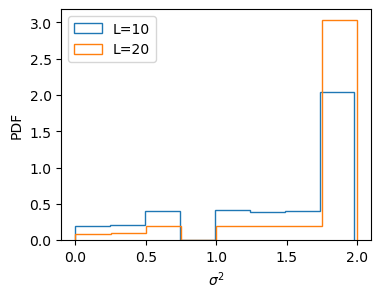

In [117]:
fig,ax=plt.subplots(figsize=(4,3))
for i in range(0,2):
    (ax.hist(var_FDW_list_short[i,0],label=f'L={L_list[i]}',histtype='step',bins=8,density=True))
ax.legend()

ax.set_xlabel('$\sigma^2$')
ax.set_ylabel('PDF')
# fig.savefig('../Paper_CIPT/Fig/circ_fluct_traj_fluct_0.5.pdf',bbox_inches='tight')

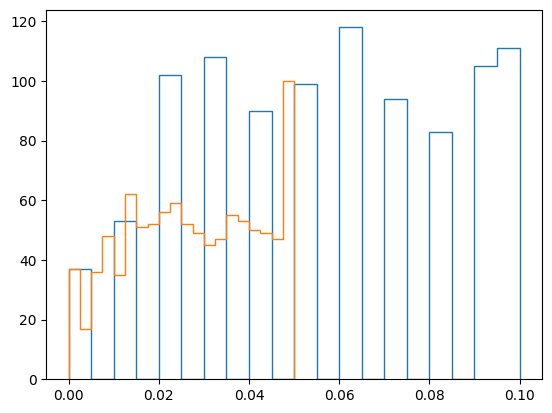

In [36]:
for i in range(2):
    (plt.hist(var_list[i,0],label=f'L={L_list[i]}',histtype='step',bins=20))

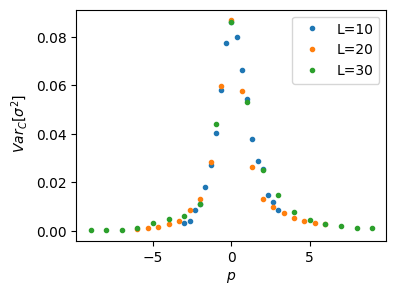

In [68]:
fig,ax=plt.subplots(figsize=(4,3))
for L_idx, L in enumerate(L_list):
    x = (p_list-0.5)
    y = var_list[L_idx].var(axis=1)
    x = (p_list-0.5)*L
    y = var_list[L_idx].var(axis=1)*L**2
    ax.plot(x,y,'.',label=f'L={L}')
ax.legend()
ax.set_xlabel('$p$')
ax.set_ylabel(r' $Var_C[\sigma^2]$')

fig.savefig('../Paper_CIPT/Fig/circ_fluct_traj_fluct_p.pdf',bbox_inches='tight')
# ax.xlabel('$(p-0.5)L$')
# ax.ylabel(r' $Var_C[\sigma^2] ~L^2$')

Text(0, 0.5, ' $Var_C[\\sigma^2]$')

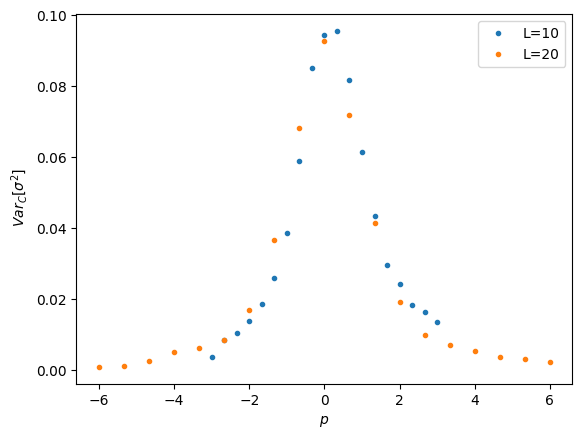

In [ ]:
for L_idx, L in enumerate(L_list):
    x = (p_list-0.5)
    y = var_list[L_idx].var(axis=1)
    x = (p_list-0.5)*L
    y = var_list[L_idx].var(axis=1)*L**2
    plt.plot(x,y,'.',label=f'L={L}')
plt.legend()
plt.xlabel('$p$')
plt.ylabel(r' $Var_C[\sigma^2]$')
# plt.xlabel('$(p-0.5)L$')
# plt.ylabel(r' $Var_C[\sigma^2] ~L^2$')

Text(0, 0.5, ' $Var_C[\\sigma^2]$')

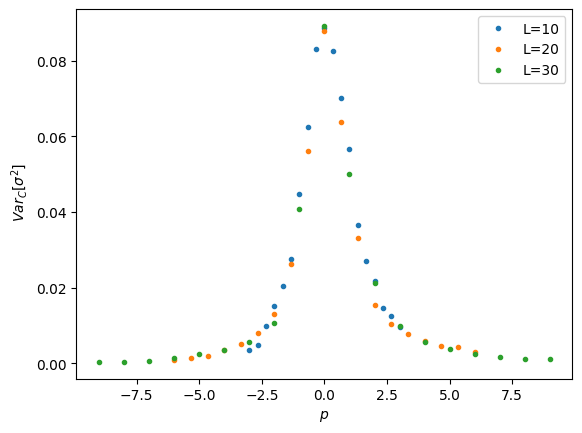

In [ ]:
for L_idx, L in enumerate(L_list):
    x = (p_list-0.5)
    y = var_list[L_idx].var(axis=1)
    x = (p_list-0.5)*L
    y = var_list[L_idx].var(axis=1)*L**2
    plt.plot(x,y,'.',label=f'L={L}')
plt.legend()
plt.xlabel('$p$')
plt.ylabel(r' $Var_C[\sigma^2]$')
# plt.xlabel('$(p-0.5)L$')
# plt.ylabel(r' $Var_C[\sigma^2] ~L^2$')

Text(0, 0.5, ' $Var_C[\\sigma^2]$')

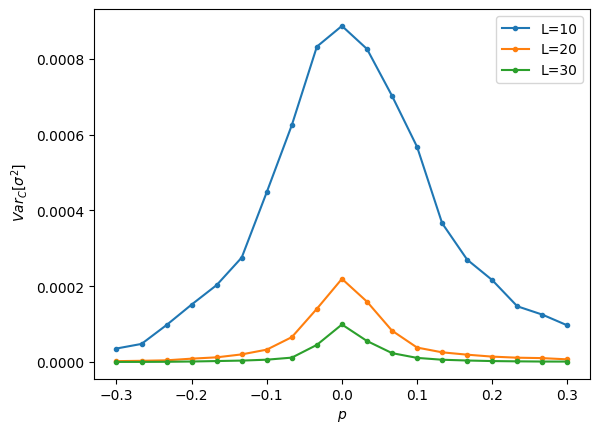

In [ ]:
for L_idx, L in enumerate(L_list):
    x = (p_list-0.5)
    y = var_list[L_idx].var(axis=1)
    # x = (p_list-0.5)*L
    # y = var_list[L_idx].var(axis=1)*L**2
    plt.plot(x,y,'.-',label=f'L={L}')
plt.legend()
plt.xlabel('$p$')
plt.ylabel(r' $Var_C[\sigma^2]$')
# plt.xlabel('$(p-0.5)L$')
# plt.ylabel(r' $Var_C[\sigma^2] ~L^2$')

In [91]:
for L_idx, L in enumerate(L_list):
    # x = (p_list-0.5)
    # y = var_list[L_idx].var(axis=1)
    x = (p_list-0.5)*L
    y = var_list[L_idx].var(axis=1)*L**2
    plt.plot(x,y,'.-',label=f'L={L}')
plt.legend()
plt.xlabel('$p$')
plt.ylabel(r' $Var_C[\sigma^2]$')
plt.xlabel('$(p-0.5)L$')
plt.ylabel(r' $Var_C[\sigma^2] ~L^2$')

[0.1,
 0.020000000000000004,
 0.07,
 0.1,
 0.1,
 0.0,
 0.03,
 0.05,
 0.060000000000000005,
 0.05,
 0.0,
 0.1,
 0.05,
 0.1,
 0.03,
 0.08,
 0.0,
 0.07,
 0.1,
 0.09000000000000001]

In [17]:
ct.T_tensor(ct.T_tensor(ct.vec,left=True))

array([[[[0., 0.],
         [0., 0.]],

        [[1., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]]])

In [31]:
ct.R_tensor(ct.vec)

array([[[[0.125, 0.   ],
         [0.125, 0.   ]],

        [[0.125, 0.   ],
         [0.125, 0.   ]]],


       [[[0.125, 0.   ],
         [0.125, 0.   ]],

        [[0.125, 0.   ],
         [0.125, 0.   ]]]])

In [49]:
z=np.array([1,2,3])

In [51]:
np.roll(z,-1)

array([2, 3, 1])

In [2]:
from scipy.special import comb


In [45]:
L=20
x=np.arange(0,21)


p = comb(L,x)/2**L
sigma2=1/L-x/L**2



In [46]:
import matplotlib.pyplot as plt

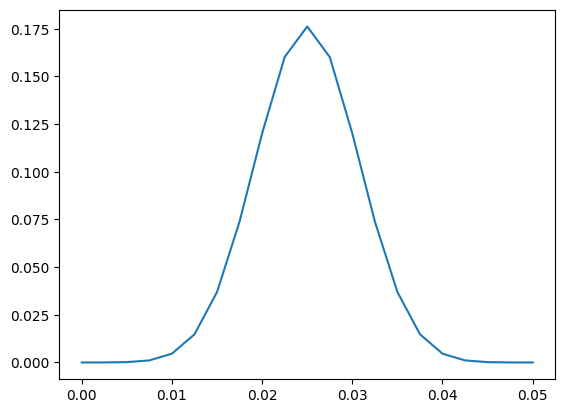

In [48]:
plt.plot(sigma2,p)

In [51]:
def pmz(sigma2,t,L,p):
    x=L/2-L**2*sigma2
    # print((t+x)/2)
    return comb( t,(t+x)/2) * p ** ((t+x)/2) * (1-p) ** ((t-x)/2)



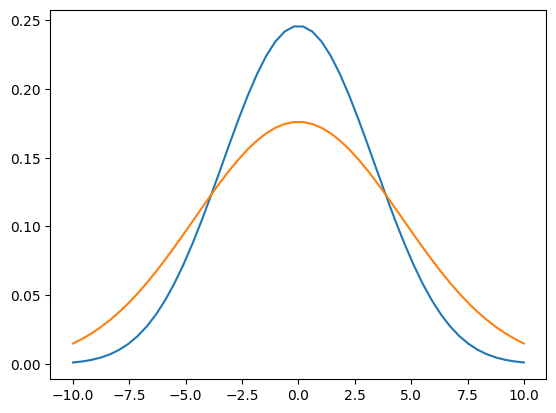

In [56]:
plt.plot(np.linspace(-10,10,),[pdf(x,t=10,p=0.5) for x in np.linspace(-10,10,)])
plt.plot(np.linspace(-10,10,),[pdf(x,t=20,p=0.5) for x in np.linspace(-10,10,)])

In [27]:
import numpy as np

In [31]:
import matplotlib.pyplot as plt

(0.0, 0.0835643918604102)

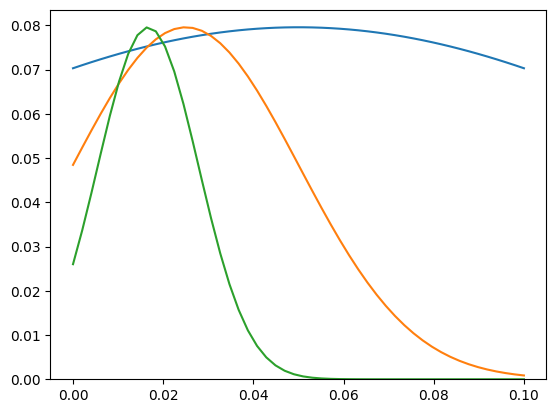

In [61]:
sigma_list = np.linspace(0,1/10)
plt.plot(sigma_list , [pmz(x,100,10,0.5) for x in sigma_list])
sigma_list = np.linspace(0,1/10)
plt.plot(sigma_list , [pmz(x,100,20,0.5) for x in sigma_list])
plt.plot(sigma_list , [pmz(x,100,30,0.5) for x in sigma_list])
plt.ylim(0,None)